In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import random

In [2]:
G = nx.read_weighted_edgelist("Contact-diaries-network_data_2013.csv", nodetype=int)

In [3]:
color_map=['blue' for number in range(len(G.nodes()))]

In [4]:
color_map[3] = 'red'

In [5]:
opt = { 'node_color': color_map,
        'node_size': 50,
        'width': 1,
        'with_labels': False,
        'font_weight': 'bold'}

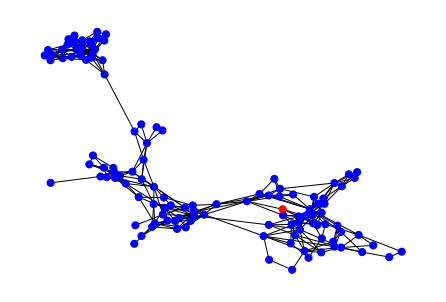

In [6]:
nx.draw(G, **opt)

Función de recuperación de los nodos, que toma un nodo y cambia su estado a "recuperado". Se abre el contacto con todos los vecinos del nodo que tienen un estado distinto de infectado.

In [10]:
def process_recovery(event, H, times, S, I, R): 
    #events are (0: time, 1: node, 2: type)

    H.nodes[event[1]]['status'] = 'recovered'
    times.append(event[0])
    S.append(S[-1])
    I.append(I[-1]-1)
    R.append(R[-1]+1)

Función de transmisión, toma al nodo y cambia su estado de susceptible a infectado. Se toma una fracción de sus vecinos y se cierran los contactos entre ellos.

In [11]:
def process_transmission(event, H, times, S, I, R, list_of_events, beta, beta_fm, gamma, Tmax): 
    
    #beta contagion rate or infection rate or transmission rate
    #gamma recovery rate
    #beta_fm rate or infection rate of people that use facemask, is less than beta.
    
    #events are (0: time, 1: node, 2: type)
    if H.nodes[event[1]]['status'] == 'susceptible':

        H.nodes[event[1]]['status'] = 'infected'

        times.append(event[0])
        S.append(S[-1]-1)
        I.append(I[-1]+1)
        R.append(R[-1])
        
        

        rec_time = event[0] + random.expovariate(gamma)

        if rec_time < Tmax:
            new_event = (rec_time, event[1], 'recovery')
            list_of_events.append(new_event)
            list_of_events.sort()

        for target in H.neighbors(event[1]):
            if H.nodes[target]['status'] == 'susceptible':
                if H.nodes[target]['facemask'] == False:
                    inf_time = event[0] + random.expovariate(beta)
                else:
                    inf_time = event[0] + random.expovariate(beta_fm)
                
                if inf_time < min(rec_time, H.nodes[target]['pred_inf_time'], Tmax):
                    new_event = (inf_time, target, 'transmit')
                    list_of_events.append(new_event)
                    list_of_events.sort()
                    H.nodes[target]['pred_inf_time'] = inf_time            

In [14]:
def epidemic(H,beta,beta_fm,gamma,Tmax,fm_percentage):
    if(nx.is_connected(H)==False):
        raise ValueError("Graph H must be connected")
    
    list_of_events = []
    times, S, I, R = [0], [len(H.nodes)], [0], [0]
           
    
    
    for u in H.nodes:
        H.nodes[u]['status'] = 'susceptible'
        H.nodes[u]['pred_inf_time'] = np.inf
        H.nodes[u]['facemask'] = False
        
    fm_fraction = round(fm_percentage*(len(H.nodes)))
    fm_use = random.sample(H.nodes,fm_fraction)
    
    for u in fm_use:
        H.nodes[u]['facemask'] = True 
    
    #initial infected
    u = np.random.choice(H.nodes, size=1)[0]
    H.nodes[u]['pred_inf_time'] = 0

    #events are (time, node, type)
    event = (0, u, 'transmit')

    list_of_events.append(event)
    list_of_events.sort()
    
    while(len(list_of_events) > 0):
        event = list_of_events.pop(0)
    
        if event[2] == 'transmit':
            process_transmission(event,H, times, S, I, R, list_of_events, beta, beta_fm, gamma, Tmax)
        else:
            process_recovery(event,H, times, S, I, R)
    
    network_data = np.column_stack((times, S, I, R))
    return(network_data)

In [15]:
epidemic(G,1.5,0.5,1,50,0)

array([[  0.        , 120.        ,   0.        ,   0.        ],
       [  0.        , 119.        ,   1.        ,   0.        ],
       [  0.24639913, 118.        ,   2.        ,   0.        ],
       [  0.39247173, 117.        ,   3.        ,   0.        ],
       [  0.42995957, 116.        ,   4.        ,   0.        ],
       [  0.46960845, 115.        ,   5.        ,   0.        ],
       [  0.47377796, 114.        ,   6.        ,   0.        ],
       [  0.47697195, 113.        ,   7.        ,   0.        ],
       [  0.48523707, 112.        ,   8.        ,   0.        ],
       [  0.49216934, 111.        ,   9.        ,   0.        ],
       [  0.50498281, 110.        ,  10.        ,   0.        ],
       [  0.52283791, 109.        ,  11.        ,   0.        ],
       [  0.5269947 , 108.        ,  12.        ,   0.        ],
       [  0.52910764, 107.        ,  13.        ,   0.        ],
       [  0.5427622 , 106.        ,  14.        ,   0.        ],
       [  0.54294976, 106

In [16]:
for fm_percentage in (0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1):
    l =[]
    for i in range(5000):
        l.append(epidemic(G, 1.5, 0.5, 1, 50, fm_percentage)[-1][-1])
    arr = np.array(l)
    txt = 'face-mask_' + format(fm_percentage) + '.csv'
    np.savetxt(txt,arr,delimiter=",")

In [17]:
l =[]
for i in range(5000):
    l.append(epidemic(G, 1.5, 0.5, 1, 50, 0)[-1][-1])
arr = np.array(l)
np.savetxt('face-mask_0.csv',arr,delimiter=",")